# Text and Sentiment Analysis of DBS Bank Ltd. Banking Performance Using N-gram

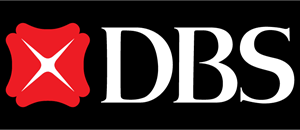

**Project Overview:**

This project aims to study the sentiment and text analysis of DBS Bank performance feedback by performing n-gram on a total of 107 consumer reviews from Jul 2019 to Nov 2023 extracted from:

 i. *Trustpilot* <br>
 ii. *BankQuality* <br>
```
Author: Aiman Hakimi (153153)
```


Suggestion: Best viewed on *Google Colab*.

##**Import Necesssary Libraries**

In [ ]:
!pip install demoji

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.9/42.9 kB 1.9 MB/s eta 0:00:00


In [ ]:
%config Completer.use_jedi=False

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams # stores various configuration settings for matplotlib plots
%matplotlib inline

# Natural Language Processing Packages
import nltk
nltk.download('punkt')
from nltk import word_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords')
stop = stopwords.words('english')
from nltk.util import ngrams
from collections import Counter
from wordcloud import WordCloud

from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay

from sklearn.pipeline import Pipeline

import spacy
# from langcat.langdetect import detect
from demoji import replace

import re
import csv
import string

import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


##**Load The Sample Datasets**

In [ ]:
# The dataset uses '?' to represent missing values as a pre-emptive measure as-
# some reviews may not appear due to customer's privacy settings.
dbs_rev = pd.read_csv('DBS_reviews_trustpilot_scrapped.csv', na_values='?')
dbs_pos_rev = pd.read_csv('dbs_pos_reviews.csv', na_values='?')
dbs_neg_rev = pd.read_csv('dbs_neg_reviews.csv', na_values='?')

##**Understanding The Sample Dataset**

In [ ]:
# Returns the first 5 positive rows
dbs_pos_rev.head()

Author Author Country        Date  Rating  \
0        Samantha             SG   12/7/2019       4   
1         Yasmine             SG   19/2/2020       5   
2    Richard Rowe             TH   27/5/2020       5   
3       Charlie S             SG   7/11/2020       4   
4  Ananya Agarwal             IN  11/12/2020       5   

                                              Review  
0     Pretty good. Just ATM can be crowded at times.  
1  A great bank for us Singaporeans!! The smart p...  
2  I've been a customer for four years and have n...  
3  Moved to Singapore from the UK a couple of yea...  
4                              wow ...bhumi meri hai

In [ ]:
# Returns the first 5 negative rows
dbs_neg_rev.head()

Author Author Country        Date  Rating  \
0  William Miller             GB  20/12/2019       1   
1    Sridhar Iyer             SG   7/10/2020       1   
2         Ioana C             GB  16/12/2020       1   
3          Matt B             US  18/12/2020       1   
4    yi xiong yao             SG  19/12/2020       1   

                                              Review  
0  I moved to Bangkok from Singapore in September...  
1  DBS is a terrible bank when it comes to how lo...  
2  Very disappointed with the customer service at...  
3  Called one month ago to ask to close an accoun...  
4  The staff at counter 8 (2nd storey,last servic...

In [ ]:
# Detect missing values for the whole scrapped dataset
dbs_rev.isna().sum()

Author            0
Author Country    0
Date              0
Rating            0
Review            0
dtype: int64

In [ ]:
pc_rating = 100 * dbs_rev['Rating'].value_counts() / len(dbs_rev)
pc_rating # percentage of ratings in the scrapped dataset

1    75.0
5    15.0
4     5.0
3     3.0
2     2.0
Name: Rating, dtype: float64

In [ ]:
dbs_pos_rev.Rating.value_counts()

5    15
4     5
Name: Rating, dtype: int64

Slightly more than 3/4 of the scrapped dataset is skewed towards Rating '1' which is the worst dissatisfaction.

<Axes: >

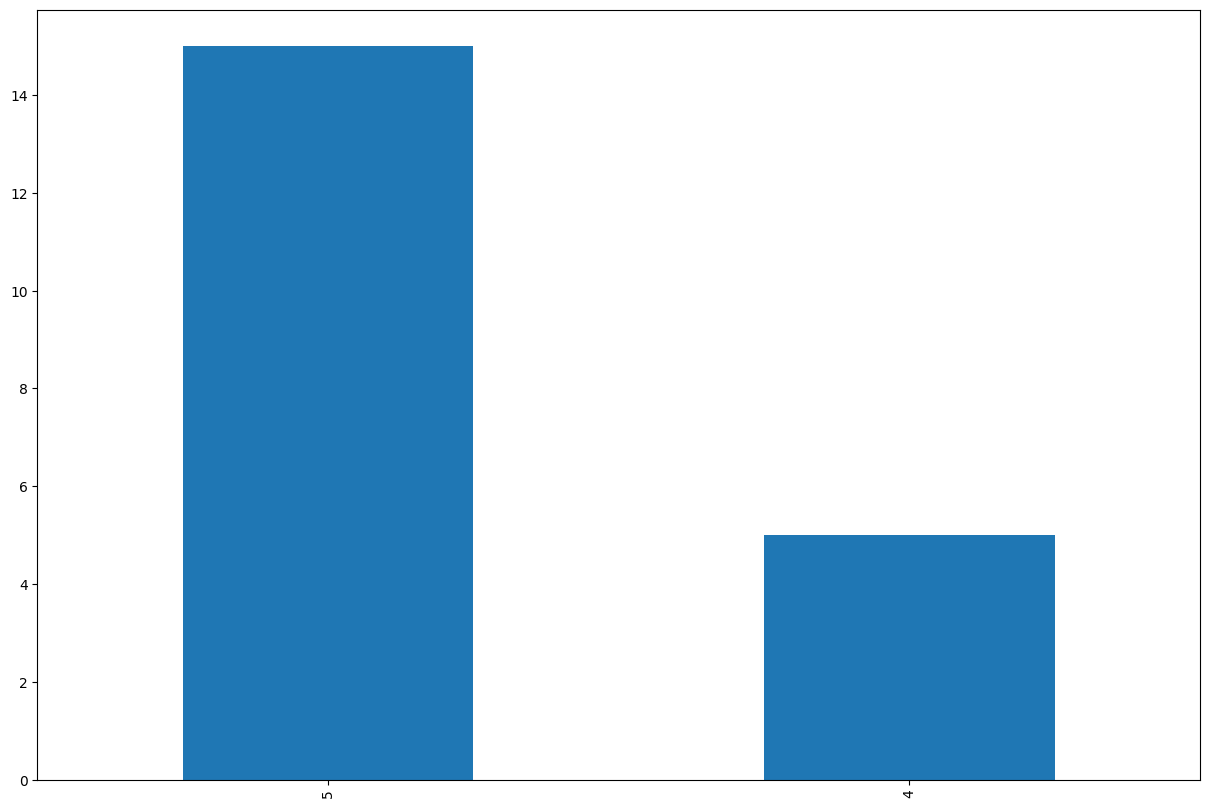

In [ ]:
rcParams['figure.figsize'] = 15,10
dbs_pos_rev.Rating.value_counts().plot(kind="bar")

The visualisation above shows that target column of the postive scrapped dataset is not equally distributed and skewed more towards Rating '5'.

<Axes: >

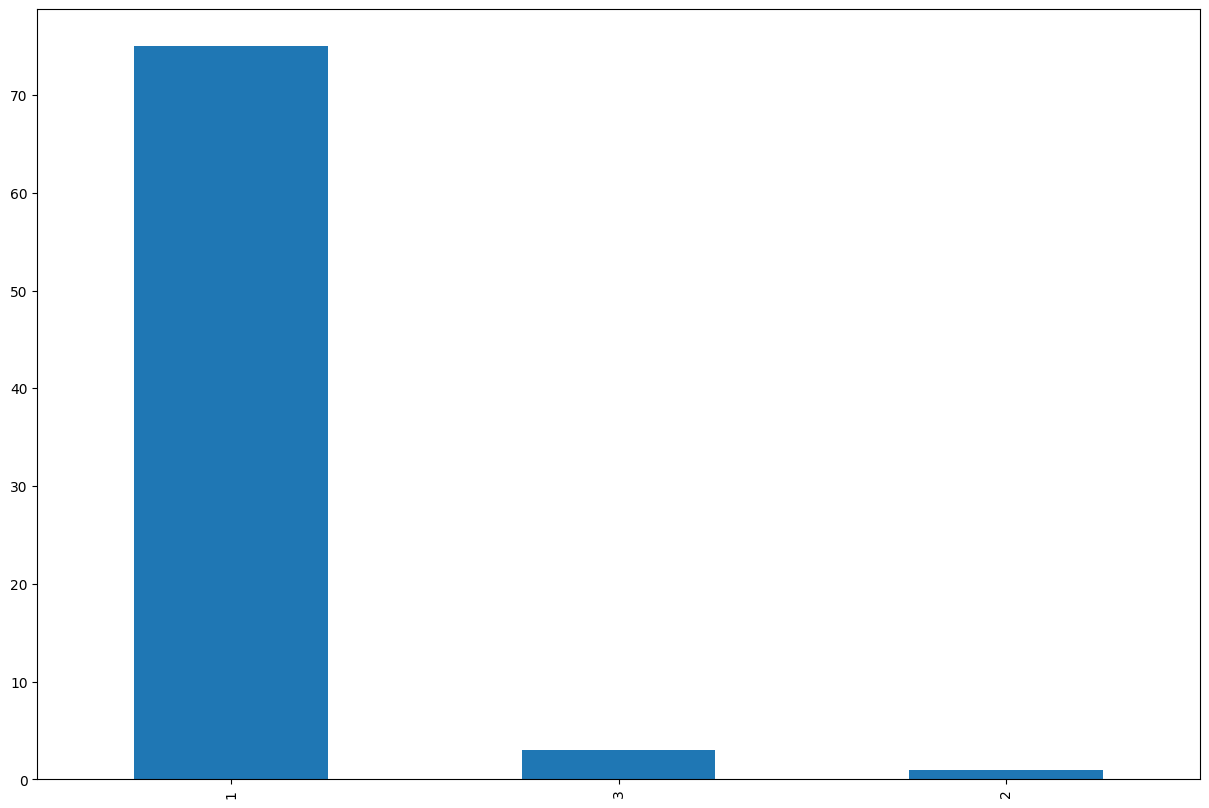

In [ ]:
rcParams['figure.figsize'] = 15,10
dbs_neg_rev.Rating.value_counts().plot(kind="bar")

The visualisation above shows that target column is incredibly skewed towards Rating '5' in the negative scrapped dataset.

In [ ]:
# Separate the dataset into different dataframes based on the label columns
best_pos_rev = dbs_pos_rev[dbs_pos_rev['Rating'] == 5] # Review Rating of 5
secbest_pos_rev = dbs_pos_rev[dbs_pos_rev['Rating'] == 4] # Review Rating of 4

print(best_pos_rev.shape)
print(secbest_pos_rev.shape)

(15, 5)
(5, 5)


In [ ]:
best_pos_rev_len = best_pos_rev['Review'].str.len()
secbest_pos_rev_len = secbest_pos_rev['Review'].str.len()

print(f"The maximum length of string in reviews of rating of 5 is {max(best_pos_rev_len)} words.")
print(f"The maximum length of string in reviews of rating of 4 is {max(secbest_pos_rev_len)} words.")

The maximum length of string in reviews of rating of 5 is 2000 words.
The maximum length of string in reviews of rating of 4 is 1375 words.


##**Data Pre-processing**
Perform data preprocessing such as **tokenisations**, **stop words removal**, **special characters/ alphabets handling** and **normalisation (lowercase conversion)**.

###**Tokenisation, Stop Words Removal, Special Characters Handling and Normalisation (Lowercase Conversion)**

In [ ]:
nltk.download('punkt')
import nltk

def tokeniseandstopwords(Review):
  # Load spaCy model
  nlp = spacy.load("en_core_web_sm")
  # Process the review
  doc = nlp(Review)
  # Extract tokens and remove stop words
  tokens = [token.text for token in doc if not token.is_stop]
  # Join the remaining words
  joined_words = " ".join(tokens)

  return joined_words

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
!pip install demoji
import demoji

def _remove_emojis(Review):
    return demoji.replace(Review)  # Replace emojis based on demoji version

'''Make reviews lowercase, remove reviews in square brackets, remove links,
  remove punctuation and remove words containing numbers.'''
def clean_reviews(Review):
    crev = str(Review).lower()
    crev = re.sub('\[.*?\]', '', crev)
    crev = re.sub('https?://\S+|www\.\S+', '', crev)
    crev = re.sub('<.*?>+', '', crev)
    crev = re.sub('[%s]' % re.escape(string.punctuation), '', crev)
    crev = re.sub('\n', '', crev)
    crev = re.sub('\w*\d\w*', '', crev)
    crev = re.sub(r"\s{2,}", " ", crev)
    crev = _remove_emojis(crev)

    return crev  # return clean reviews only

####**Preprocessing of Positive and Negative Scrapped Dataset**

#####Positive Scrapped Dataset

In [ ]:
best_pos_rev['Review'] = best_pos_rev['Review'].apply(lambda x:clean_reviews(x))
secbest_pos_rev['Review'] = secbest_pos_rev['Review'].apply(lambda x:clean_reviews(x))

best_pos_rev['Review'] = best_pos_rev['Review'].apply(tokeniseandstopwords)
secbest_pos_rev['Review'] = secbest_pos_rev['Review'].apply(tokeniseandstopwords)

In [ ]:
# Merge dataframes after cleaning and tokenization
merged_pos_reviews = pd.concat([best_pos_rev, secbest_pos_rev]).reset_index(drop=True)

# Identify indices of best_pos_rev and secbest_pos_rev rows in dbs_pos_rev
best_pos_indices = dbs_pos_rev[dbs_pos_rev['Rating'] == 5].index
secbest_pos_indices = dbs_pos_rev[dbs_pos_rev['Rating'] == 4].index

# Update the corresponding rows in dbs_pos_rev with merged_pos_reviews
dbs_pos_rev.loc[best_pos_indices, :] = merged_pos_reviews[merged_pos_reviews['Rating'] == 5]
dbs_pos_rev.loc[secbest_pos_indices, :] = merged_pos_reviews[merged_pos_reviews['Rating'] == 4]

dbs_pos_rev.head()

Author Author Country        Date  Rating  \
0                  NaN            NaN         NaN     NaN   
1         Richard Rowe             TH   27/5/2020     5.0   
2       Ananya Agarwal             IN  11/12/2020     5.0   
3                  NaN            NaN         NaN     NaN   
4  Ashwin Krishnan P C             IN    1/4/2021     5.0   

                                    Review  
0                                      NaN  
1  ve customer years exemplary experiences  
2                       wow bhumi meri hai  
3                                      NaN  
4              internet banking best world

In [ ]:
dbs_pos_rev = dbs_pos_rev.dropna()
dbs_pos_rev.head()

Author Author Country        Date  Rating  \
1         Richard Rowe             TH   27/5/2020     5.0   
2       Ananya Agarwal             IN  11/12/2020     5.0   
4  Ashwin Krishnan P C             IN    1/4/2021     5.0   
5          Adeline Tan             SG    9/7/2021     5.0   
6            cindy win             SG   17/7/2021     5.0   

                                              Review  
1            ve customer years exemplary experiences  
2                                 wow bhumi meri hai  
4                        internet banking best world  
5  thank yr kind assistance service oriented n ch...  
6  customer service adviser yanty helpful happy a...

#####Negative Scrapped Dataset

In [ ]:
# Separate the dataset into different dataframes based on the label columns
worst_neg_rev = dbs_neg_rev[(dbs_neg_rev['Rating'] == 1) |
                            (dbs_neg_rev['Rating'] == 2)] # Review Rating of 1 and 2
bad_neg_rev = dbs_neg_rev[dbs_neg_rev['Rating'] == 3] # Review Rating of 3

worst_neg_rev['Review'] = worst_neg_rev['Review'].apply(lambda x:clean_reviews(x))
bad_neg_rev['Review'] = bad_neg_rev['Review'].apply(lambda x:clean_reviews(x))

worst_neg_rev['Review'] = worst_neg_rev['Review'].apply(tokeniseandstopwords)
bad_neg_rev['Review'] = bad_neg_rev['Review'].apply(tokeniseandstopwords)

In [ ]:
# Merge dataframes after cleaning and tokenization
merged_neg_reviews = pd.concat([worst_neg_rev, bad_neg_rev]).reset_index(drop=True)

# Identify indices of worst_neg_rev and bad_neg_rev rows in dbs_neg_rev
worst_neg_indices = dbs_neg_rev[(dbs_neg_rev['Rating'] == 1) |
                                (dbs_neg_rev['Rating'] == 2)].index
bad_neg_indices = dbs_neg_rev[dbs_neg_rev['Rating'] == 3].index

# Update the corresponding rows in dbs_neg_rev with merged_neg_reviews
dbs_neg_rev.loc[worst_neg_indices, :] = merged_neg_reviews[(merged_neg_reviews['Rating'] == 1) |
                                                           (merged_neg_reviews['Rating'] == 2)]
dbs_neg_rev.loc[bad_neg_indices, :] = merged_neg_reviews[merged_neg_reviews['Rating'] == 3]

dbs_neg_rev.head()

Author Author Country        Date  Rating  \
0  William Miller             GB  20/12/2019     1.0   
1    Sridhar Iyer             SG   7/10/2020     1.0   
2         Ioana C             GB  16/12/2020     1.0   
3          Matt B             US  18/12/2020     1.0   
4    yi xiong yao             SG  19/12/2020     1.0   

                                              Review  
0  moved bangkok singapore september intended lar...  
1  dbs terrible bank comes long wait branches tim...  
2  disappointed customer service dbs customer yea...  
3  called month ago ask close account said hold a...  
4  staff counter storeylast servicing counter num...

In [ ]:
dbs_neg_rev = dbs_neg_rev.dropna()
dbs_neg_rev.head()

Author Author Country        Date  Rating  \
0  William Miller             GB  20/12/2019     1.0   
1    Sridhar Iyer             SG   7/10/2020     1.0   
2         Ioana C             GB  16/12/2020     1.0   
3          Matt B             US  18/12/2020     1.0   
4    yi xiong yao             SG  19/12/2020     1.0   

                                              Review  
0  moved bangkok singapore september intended lar...  
1  dbs terrible bank comes long wait branches tim...  
2  disappointed customer service dbs customer yea...  
3  called month ago ask close account said hold a...  
4  staff counter storeylast servicing counter num...

#####Merging Preprocessed Positive and Negative Scrapped Dataset

In [ ]:
dbs_rev = pd.concat([dbs_pos_rev, dbs_neg_rev]).reset_index(drop = True)
dbs_rev.head()

Author Author Country        Date  Rating  \
0         Richard Rowe             TH   27/5/2020     5.0   
1       Ananya Agarwal             IN  11/12/2020     5.0   
2  Ashwin Krishnan P C             IN    1/4/2021     5.0   
3          Adeline Tan             SG    9/7/2021     5.0   
4            cindy win             SG   17/7/2021     5.0   

                                              Review  
0            ve customer years exemplary experiences  
1                                 wow bhumi meri hai  
2                        internet banking best world  
3  thank yr kind assistance service oriented n ch...  
4  customer service adviser yanty helpful happy a...

##**World Cloud Generation for Text Visualisation**

A tag cloud (word cloud or wordle or weighted list in visual design) is a novelty visual representation of text data, typically used to depict keyword metadata (tags) on websites, or to visualize free form text. Tags are usually single words, and the importance of each tag is shown with font size or color. This format is useful for quickly perceiving the most prominent terms to determine its relative prominence. When used as website navigation aids, the terms are hyperlinked to items associated with the tag.

In [ ]:
def generate_word_cloud(Review):
  wordcloud = WordCloud(
      width = 3000,
      height = 2000,
      background_color = 'black').generate(str(Review))
  fig = plt.figure(
      figsize = (40, 30),
      facecolor = 'k',
      edgecolor = 'k')
  plt.imshow(wordcloud, interpolation = 'bilinear')
  plt.axis('off')
  plt.tight_layout(pad=0)
  plt.show()

###Text Visualisation (Positive Reviews)

####Rating 5

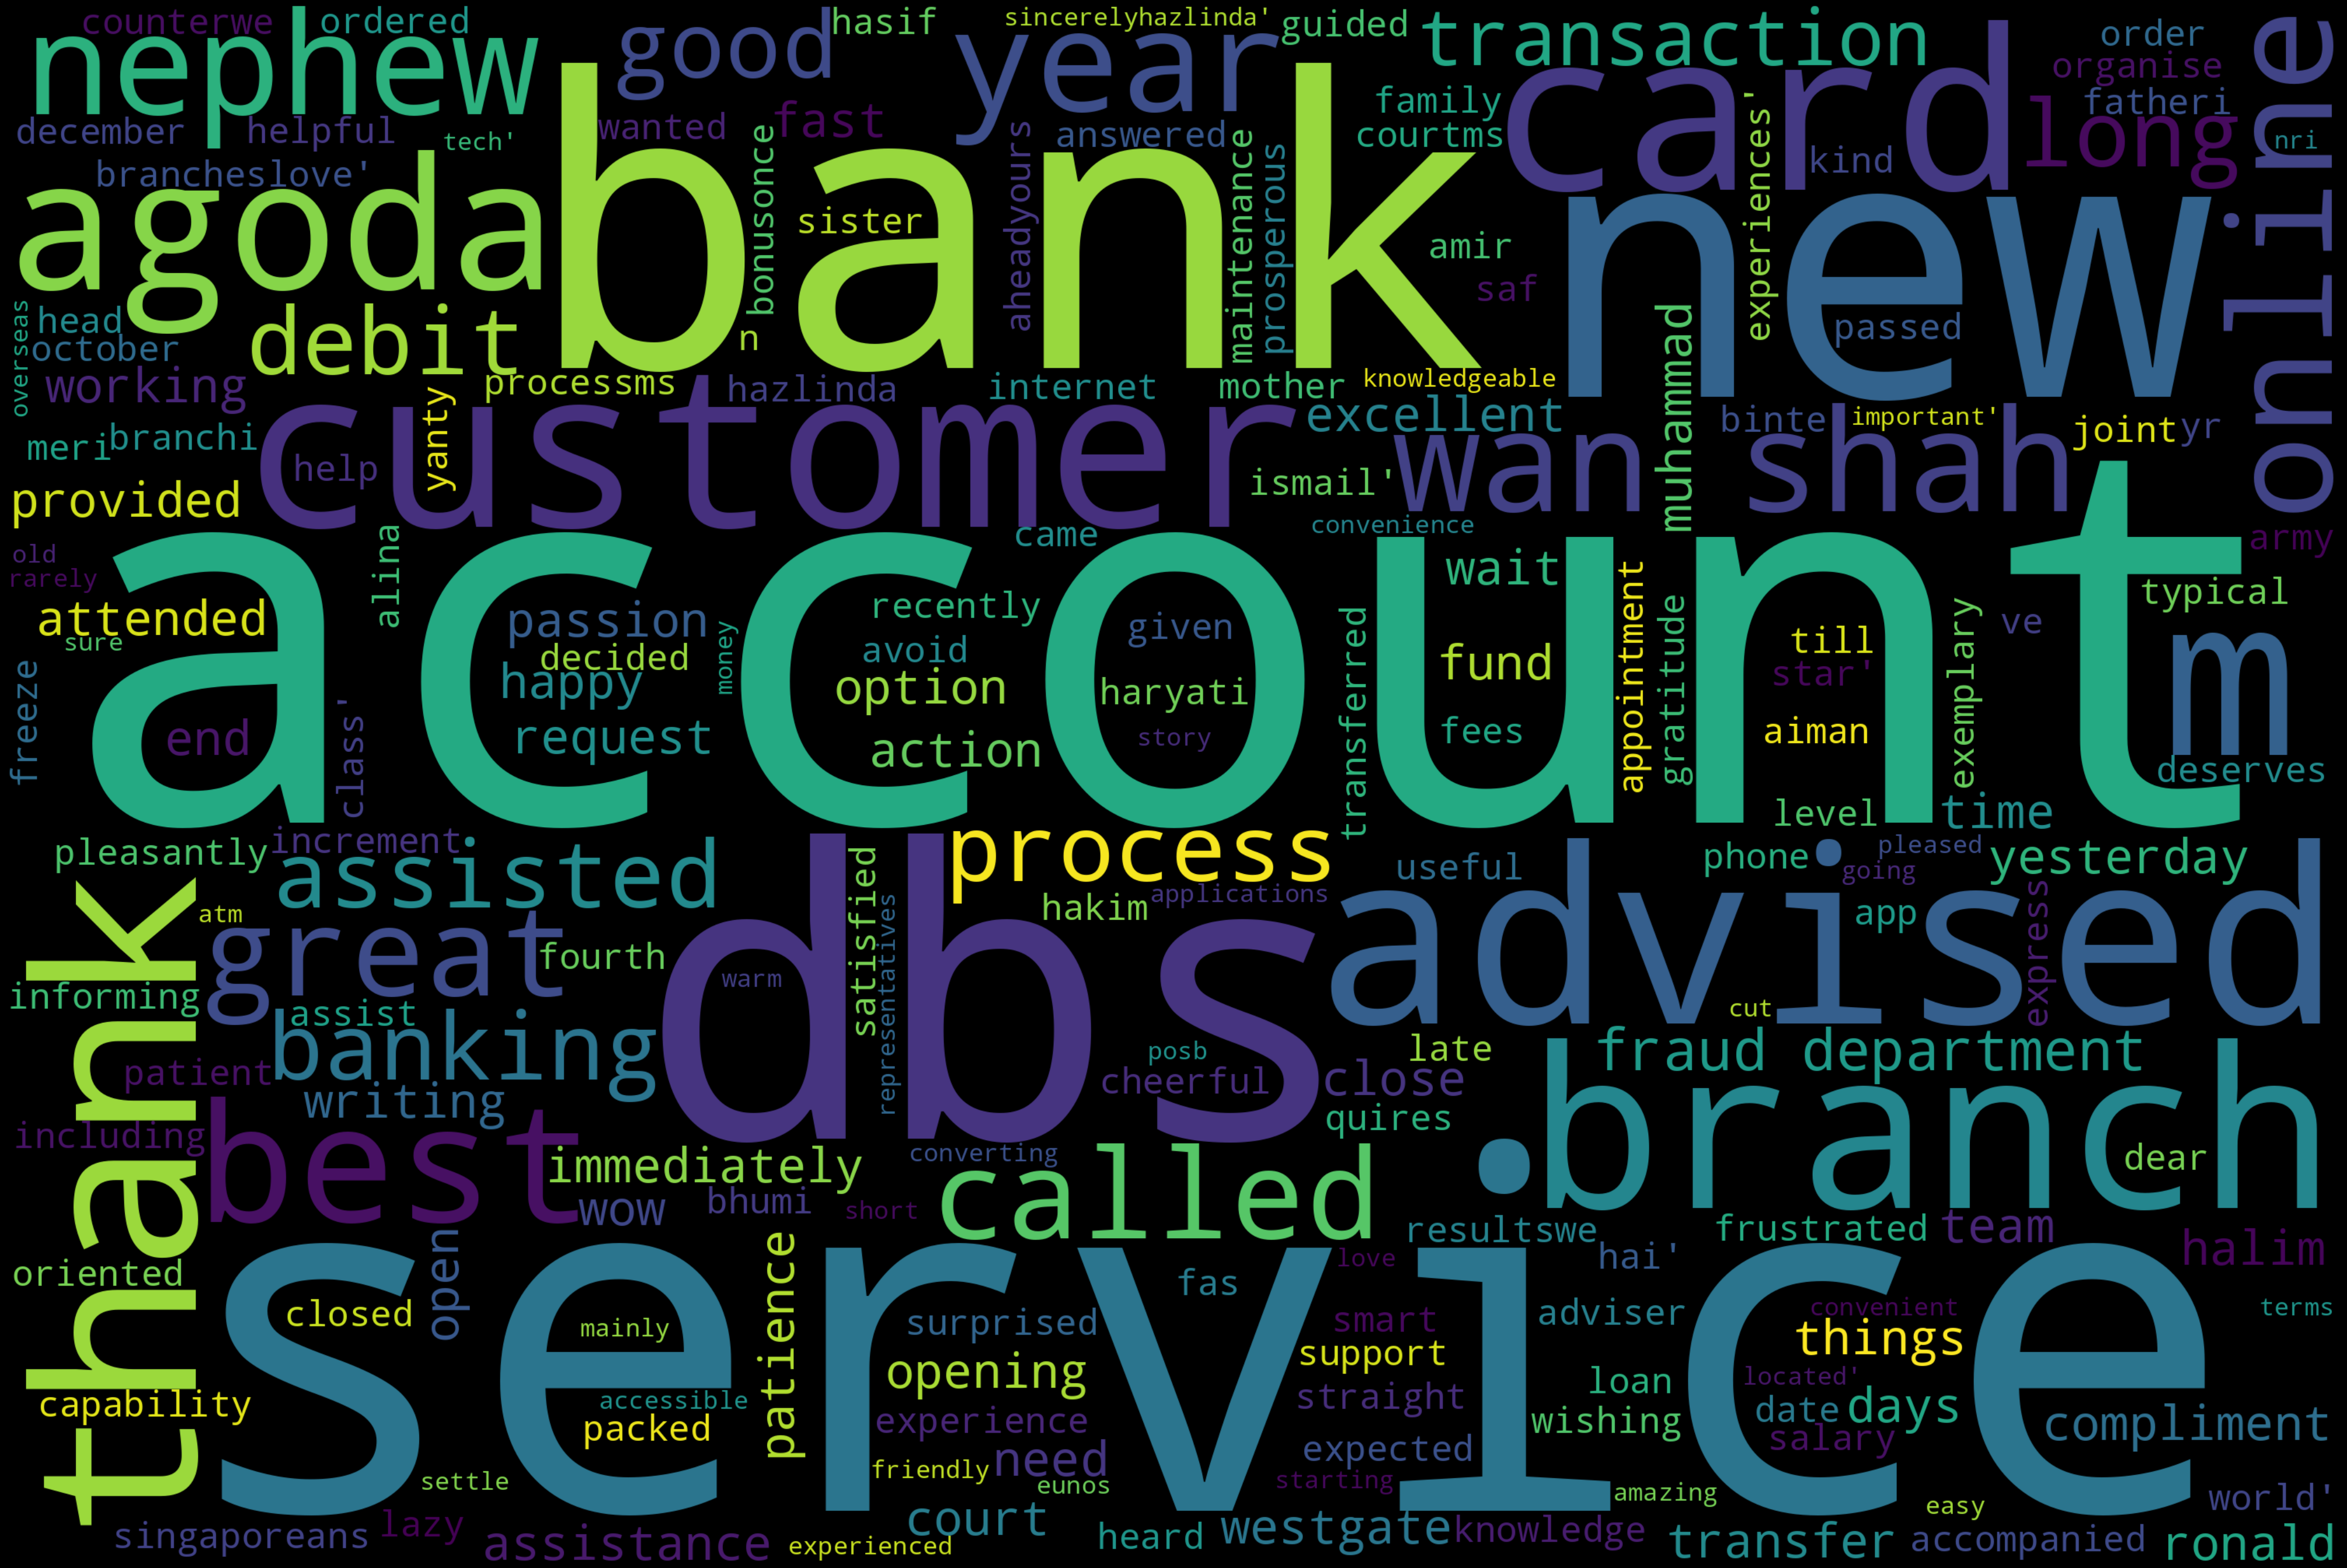

In [ ]:
best_pos_viz = best_pos_rev.Review.values
generate_word_cloud(best_pos_viz)

####Rating 4

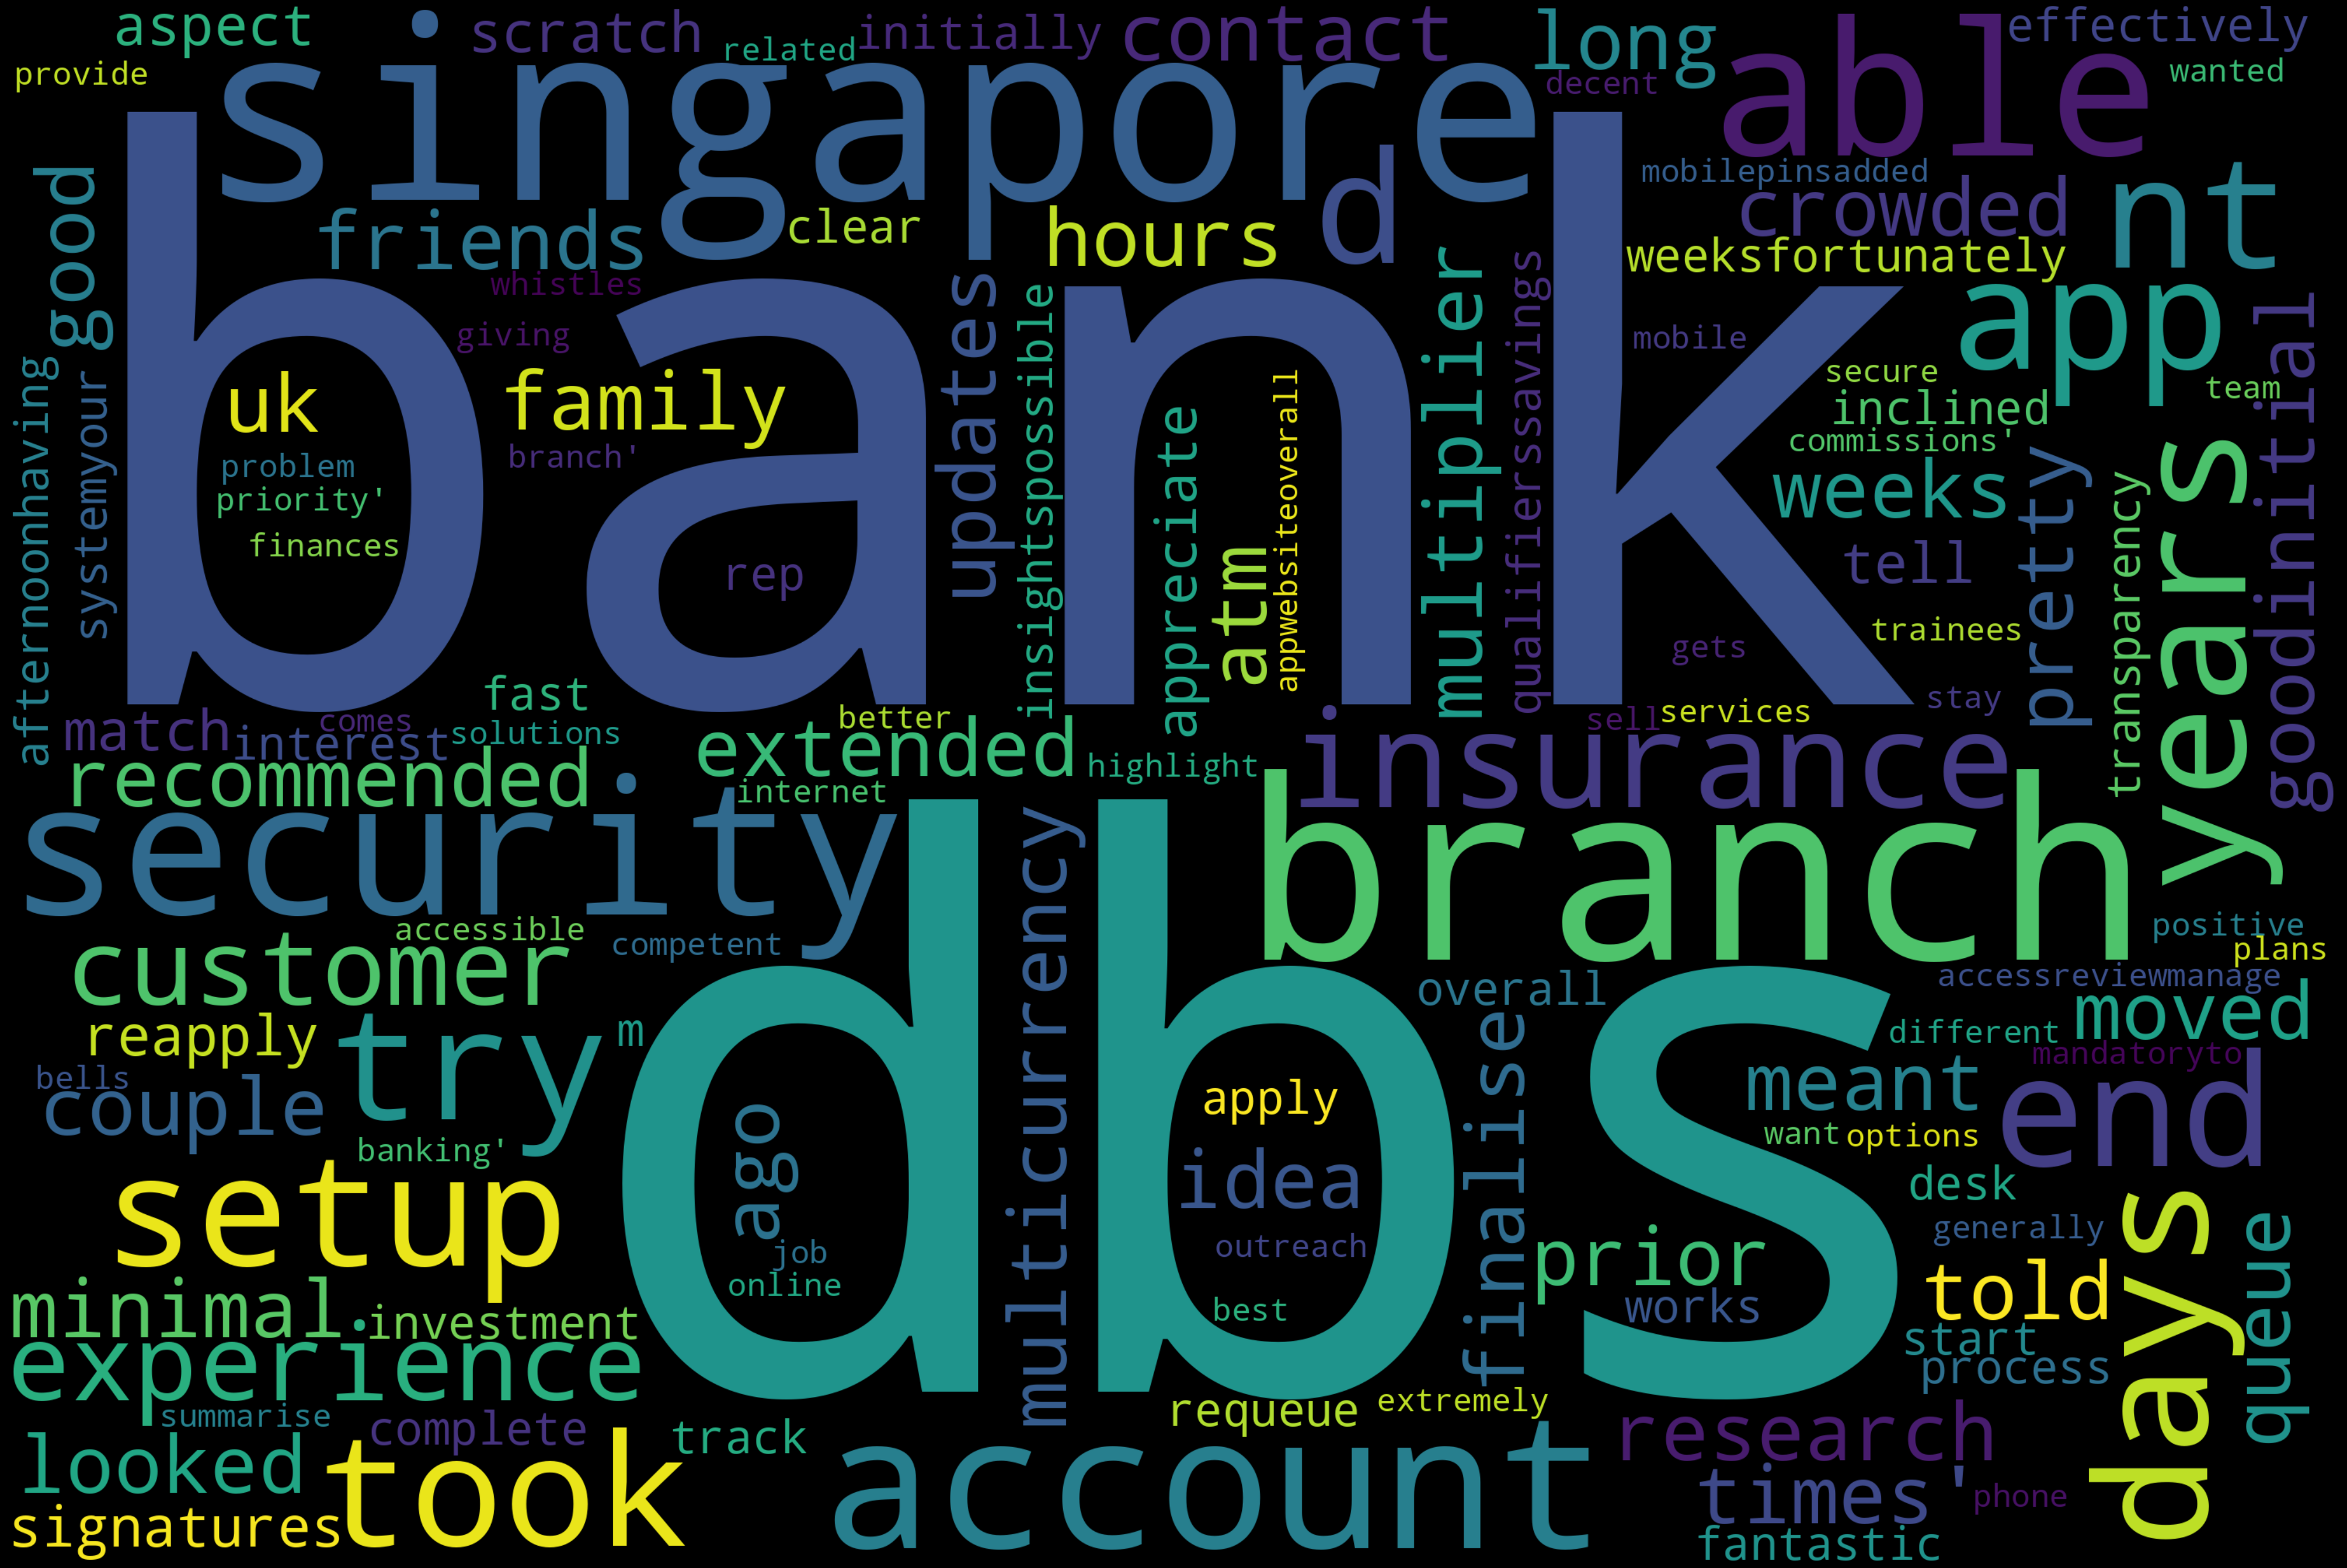

In [ ]:
secbest_pos_viz = secbest_pos_rev.Review.values
generate_word_cloud(secbest_pos_viz)

###Text Visualisation (Negative Reviews)

####Rating 3 word cloud is not available as all the NaN values have been removed and left none to sufficiently generate a word cloud🙁

####Rating 1 & 2

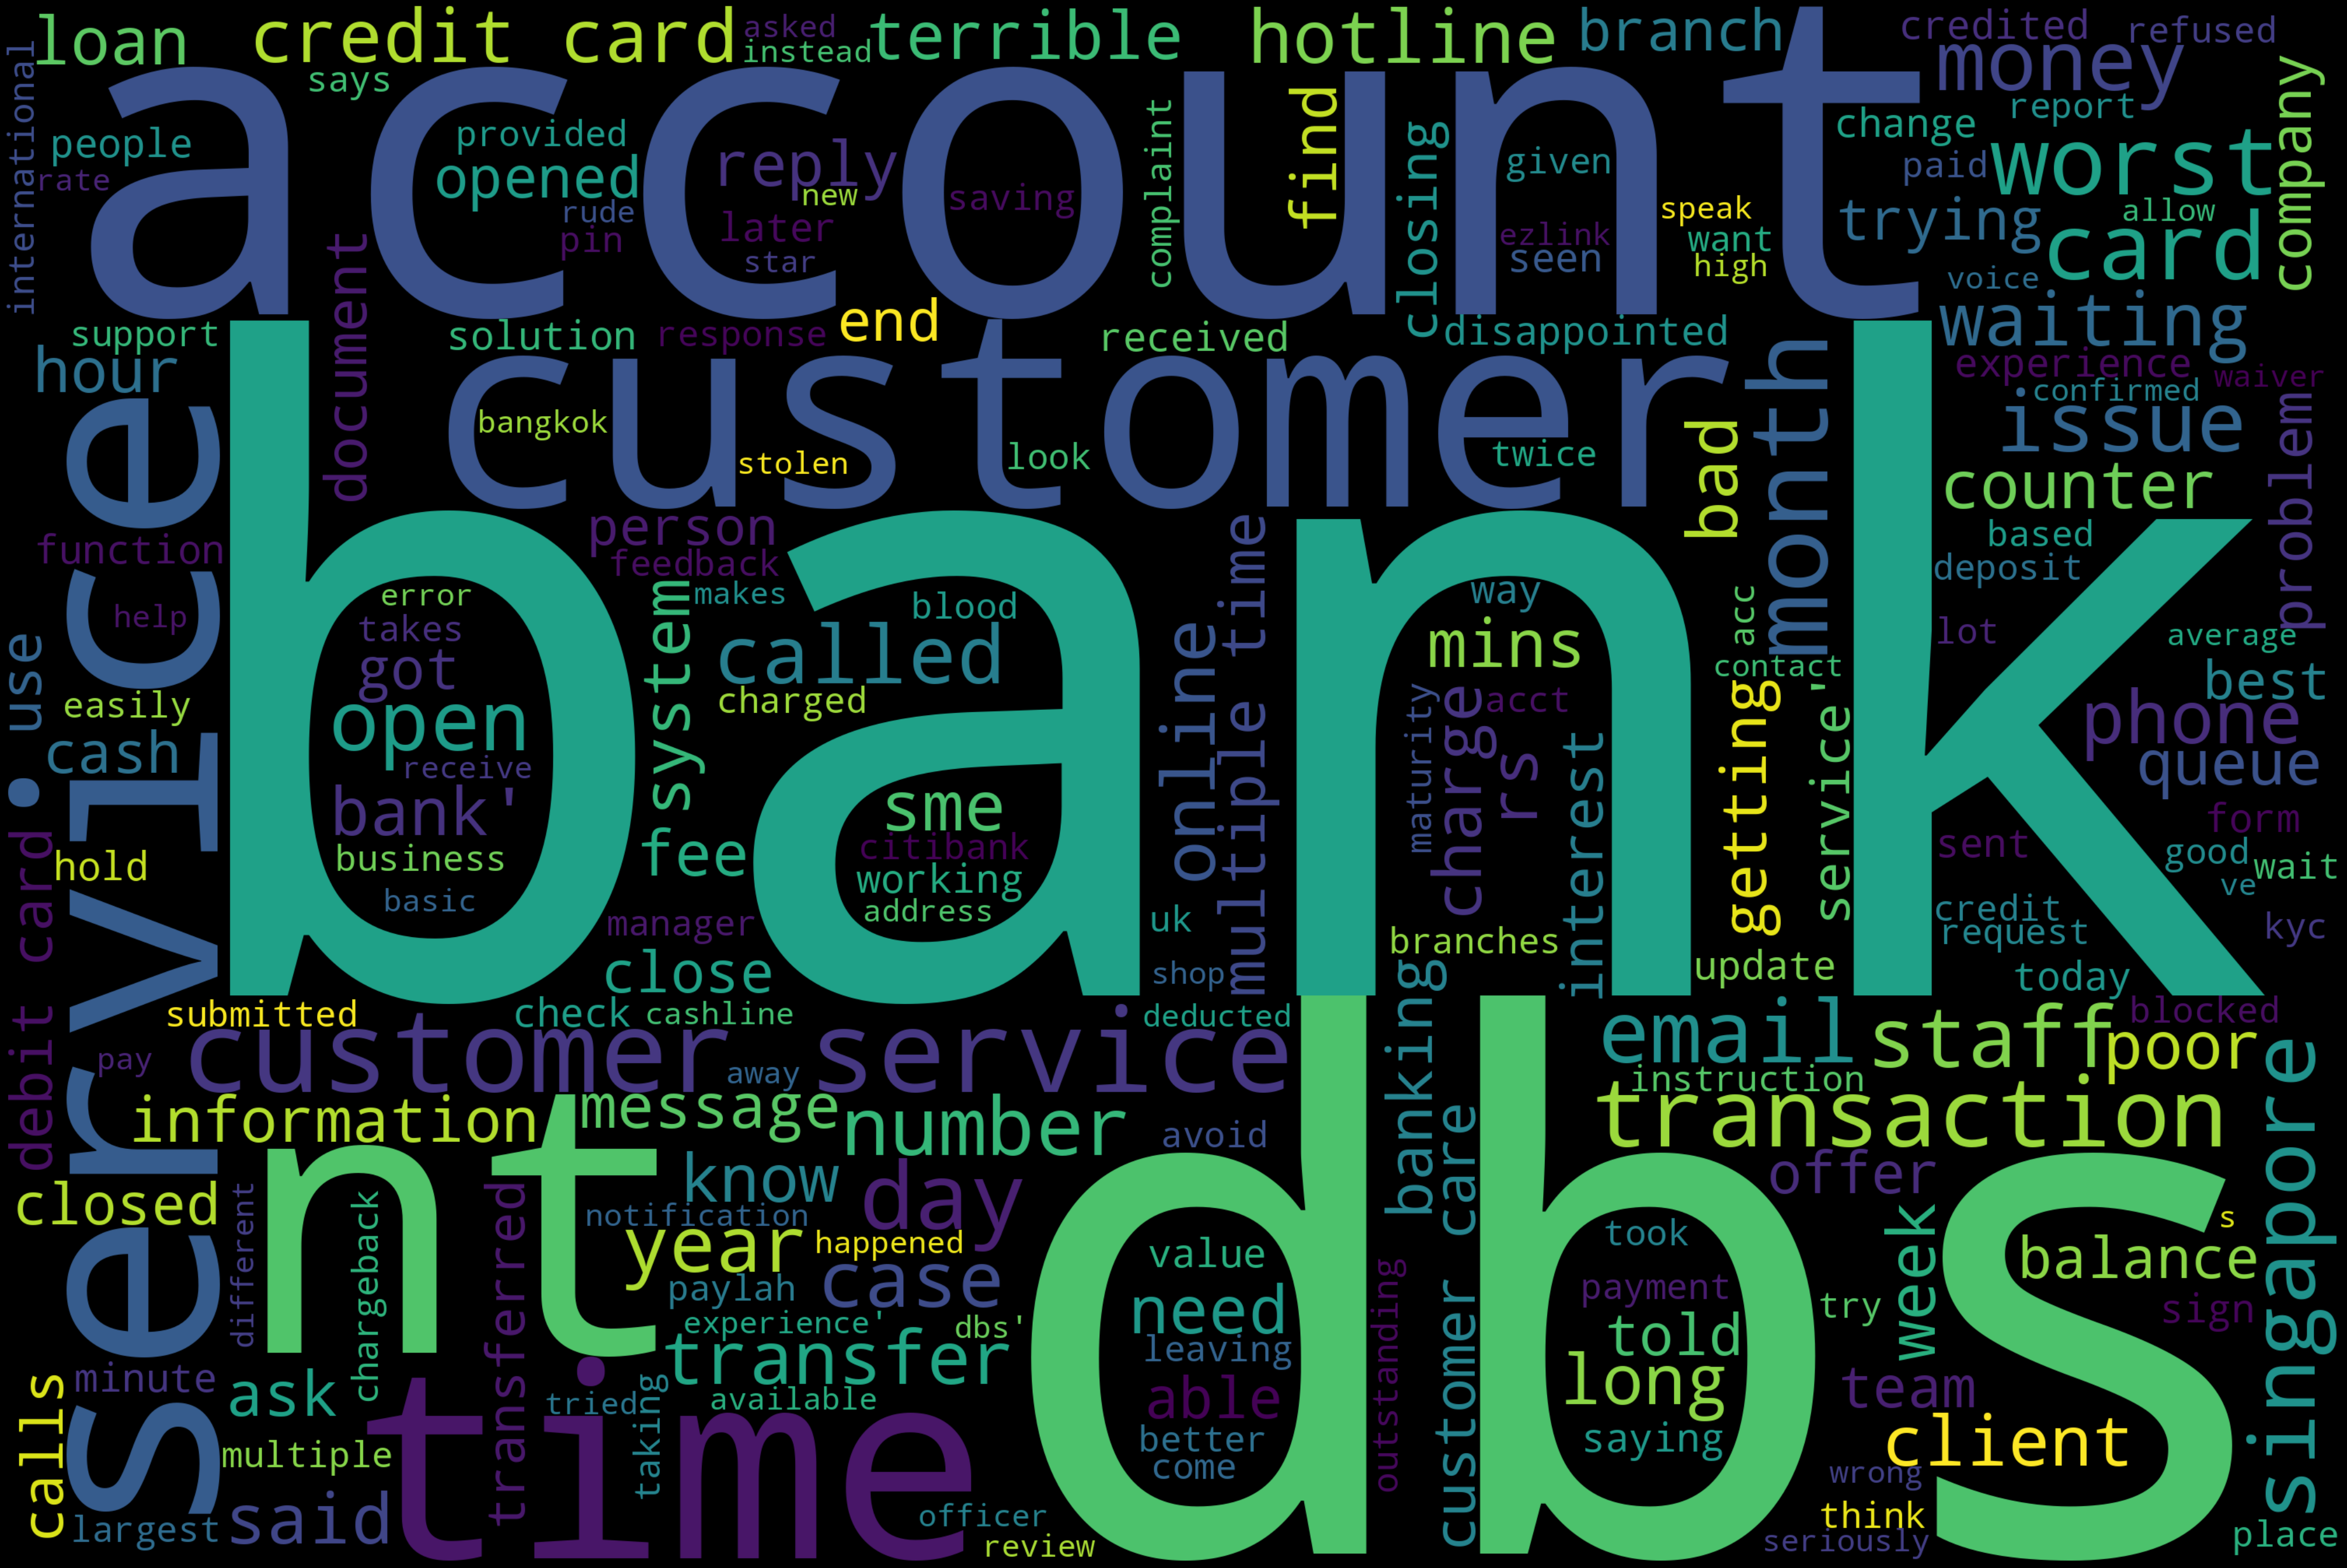

In [ ]:
worst_neg_viz = worst_neg_rev.Review.values
generate_word_cloud(worst_neg_viz)

##**N-gram**

In natural language processing, an n-gram is a sequence of n words. For example, “statistics” is a unigram (n = 1), “machine learning” is a bigram (n = 2), “natural language processing” is a trigram (n = 3). For longer n-grams, people just use their lengths to identify them, such as 4-gram, 5-gram, and so on.

###N-gram for Positive Reviews

####Unigram

In [ ]:
nltk.download('wordnet')

def basic_clean(Review):
  """
  A simple function to clean up the data. All the words that
  are not designated as a stop word is then lemmatised after
  encoding and basic regex parsing are performed.
  """
  wnl = nltk.stem.WordNetLemmatizer()
  stopwords = nltk.corpus.stopwords.words('english')
  words = re.sub(r'[^\w\s]', '', Review).split()
  return [wnl.lemmatize(word) for word in words if word not in stopwords]

[nltk_data] Downloading package wordnet to /root/nltk_data...


Text(0.5, 0, '# of Occurrences')

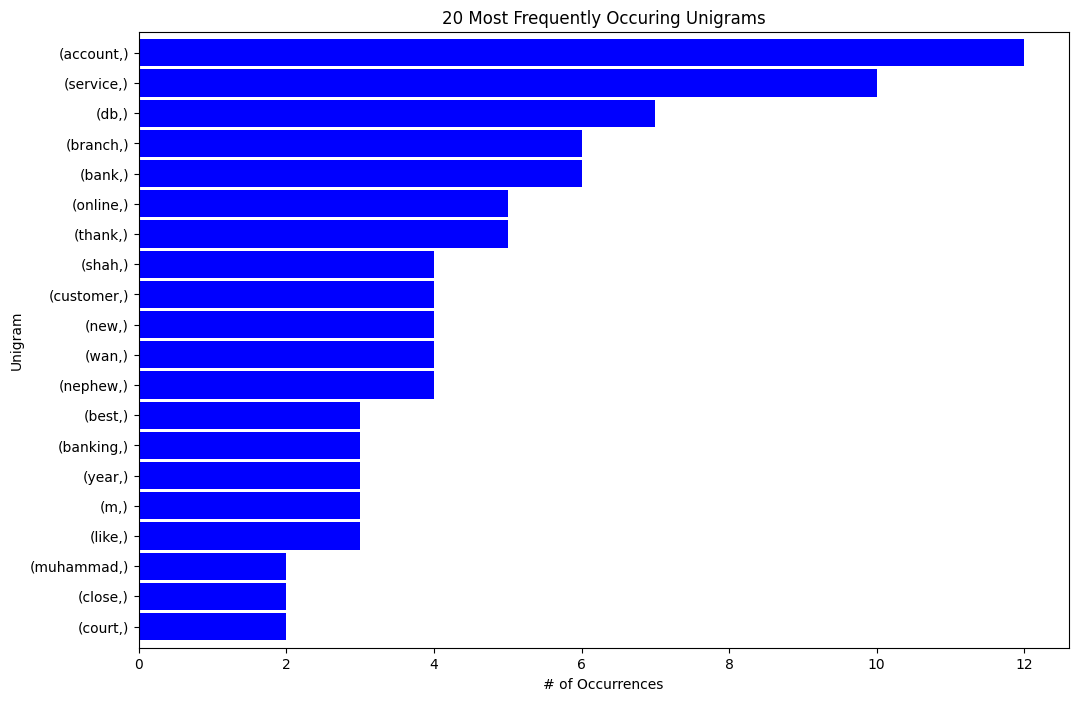

In [ ]:
pos_rev = basic_clean(''.join(str(dbs_pos_rev['Review'].tolist())))

pos_unigrams_series = (pd.Series(nltk.ngrams(pos_rev, 1)).value_counts())[:20]

pos_unigrams_series.sort_values().plot.barh(color='blue', width=.9, figsize=(12, 8))
plt.title('20 Most Frequently Occuring Unigrams')
plt.ylabel('Unigram')
plt.xlabel('# of Occurrences')

####Bigram

Text(0.5, 0, '# of Occurrences')

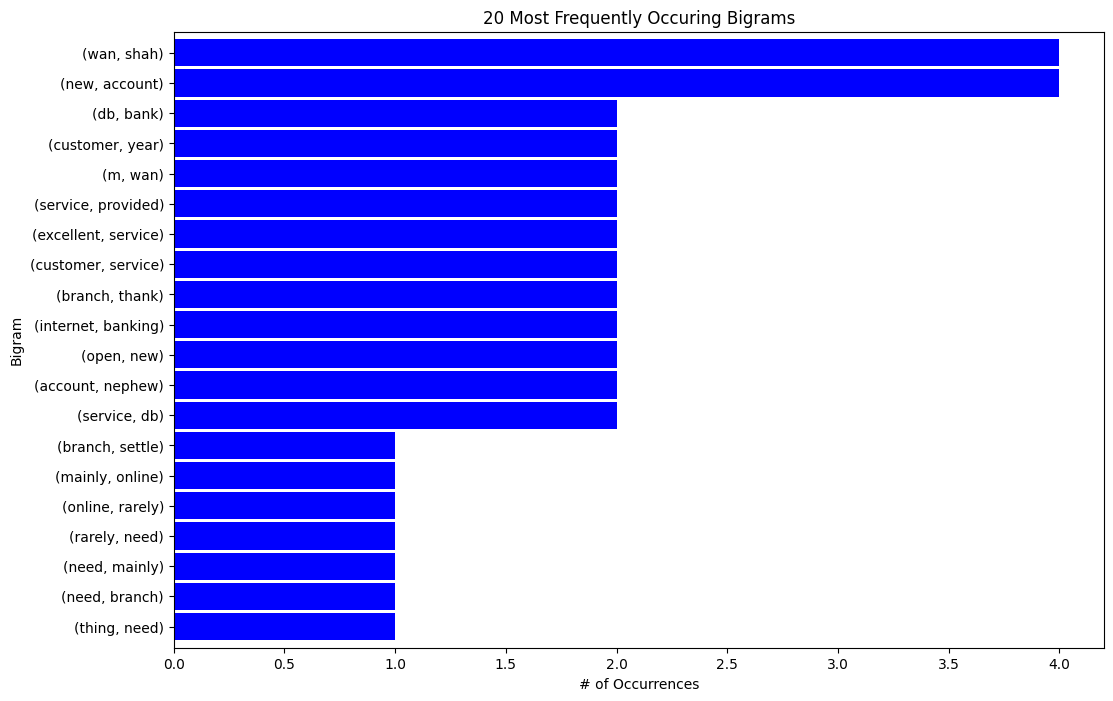

In [ ]:
pos_bigrams_series = (pd.Series(nltk.ngrams(pos_rev, 2)).value_counts())[:20]

pos_bigrams_series.sort_values().plot.barh(color='blue', width=.9, figsize=(12, 8))
plt.title('20 Most Frequently Occuring Bigrams')
plt.ylabel('Bigram')
plt.xlabel('# of Occurrences')

####Trigram

Text(0.5, 0, '# of Occurrences')

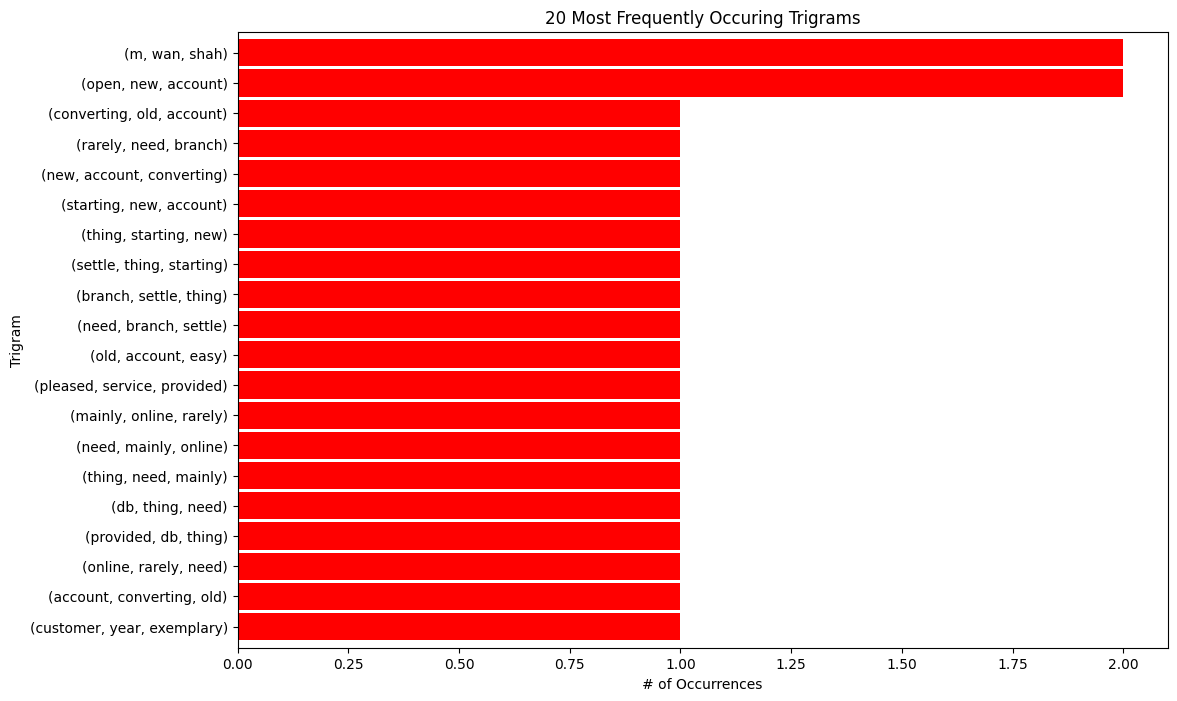

In [ ]:
pos_trigrams_series = (pd.Series(nltk.ngrams(pos_rev, 3)).value_counts())[:20]

pos_trigrams_series.sort_values().plot.barh(color='red', width=.9, figsize=(12, 8))
plt.title('20 Most Frequently Occuring Trigrams')
plt.ylabel('Trigram')
plt.xlabel('# of Occurrences')

###N-gram for Negative Reviews

####Unigram

Text(0.5, 0, '# of Occurrences')

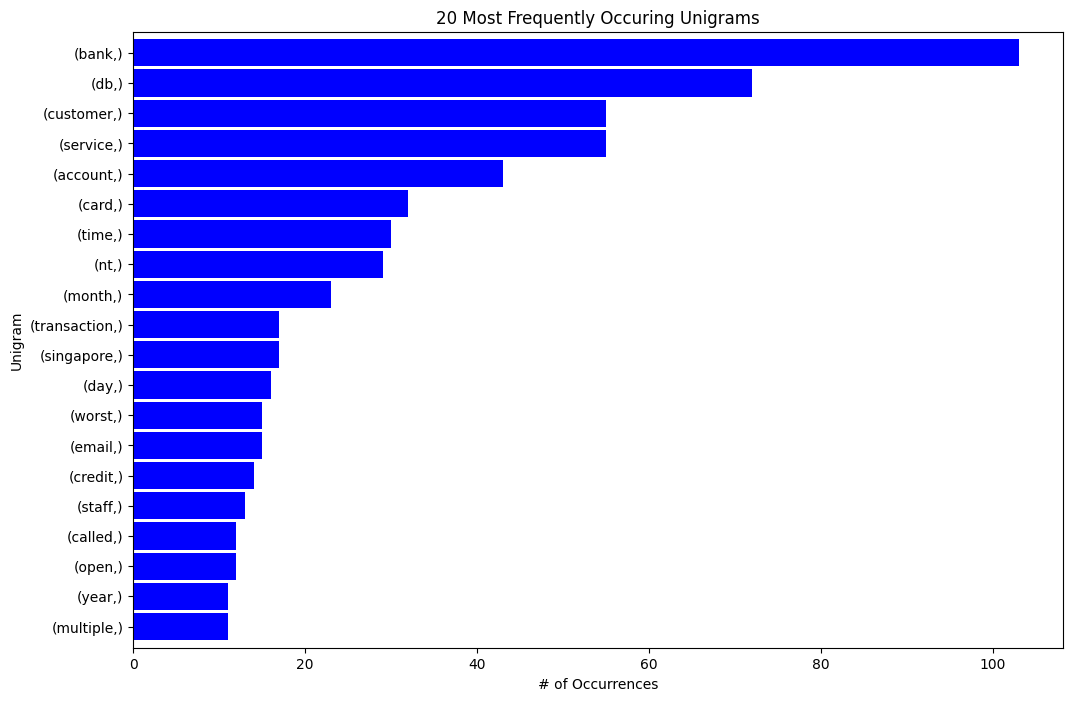

In [ ]:
neg_rev = basic_clean(''.join(str(dbs_neg_rev['Review'].tolist())))

neg_unigrams_series = (pd.Series(nltk.ngrams(neg_rev, 1)).value_counts())[:20]

neg_unigrams_series.sort_values().plot.barh(color='blue', width=.9, figsize=(12, 8))
plt.title('20 Most Frequently Occuring Unigrams')
plt.ylabel('Unigram')
plt.xlabel('# of Occurrences')

####Bigram

Text(0.5, 0, '# of Occurrences')

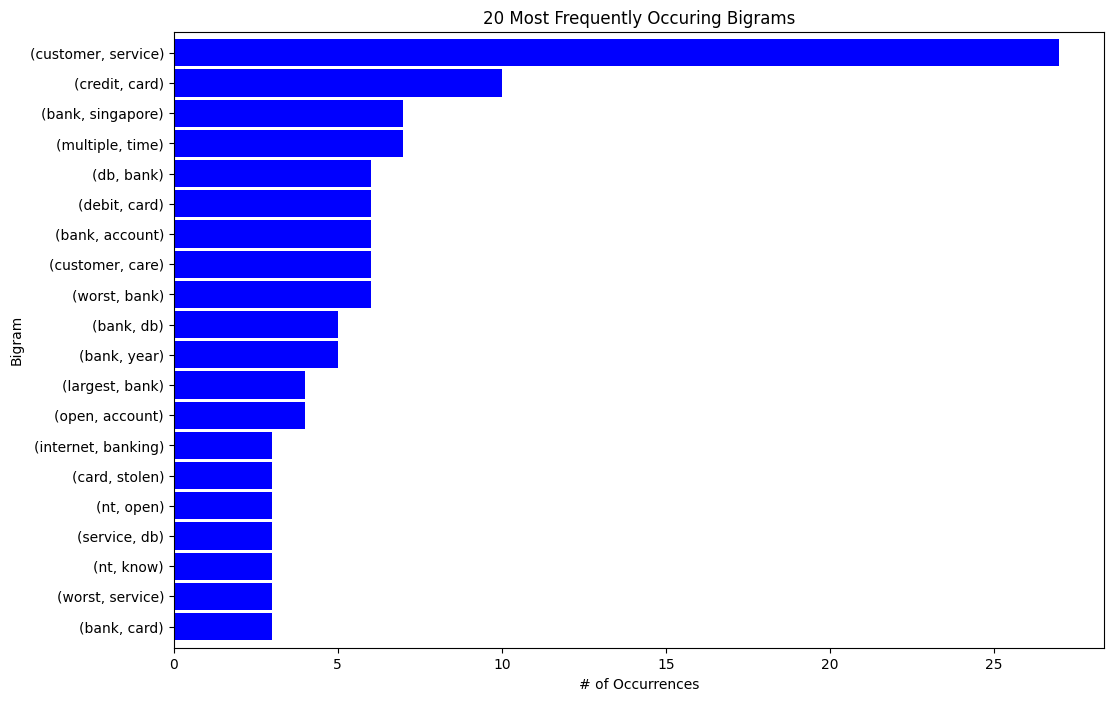

In [ ]:
neg_bigrams_series = (pd.Series(nltk.ngrams(neg_rev, 2)).value_counts())[:20]

neg_bigrams_series.sort_values().plot.barh(color='blue', width=.9, figsize=(12, 8))
plt.title('20 Most Frequently Occuring Bigrams')
plt.ylabel('Bigram')
plt.xlabel('# of Occurrences')

####Trigram

Text(0.5, 0, '# of Occurrences')

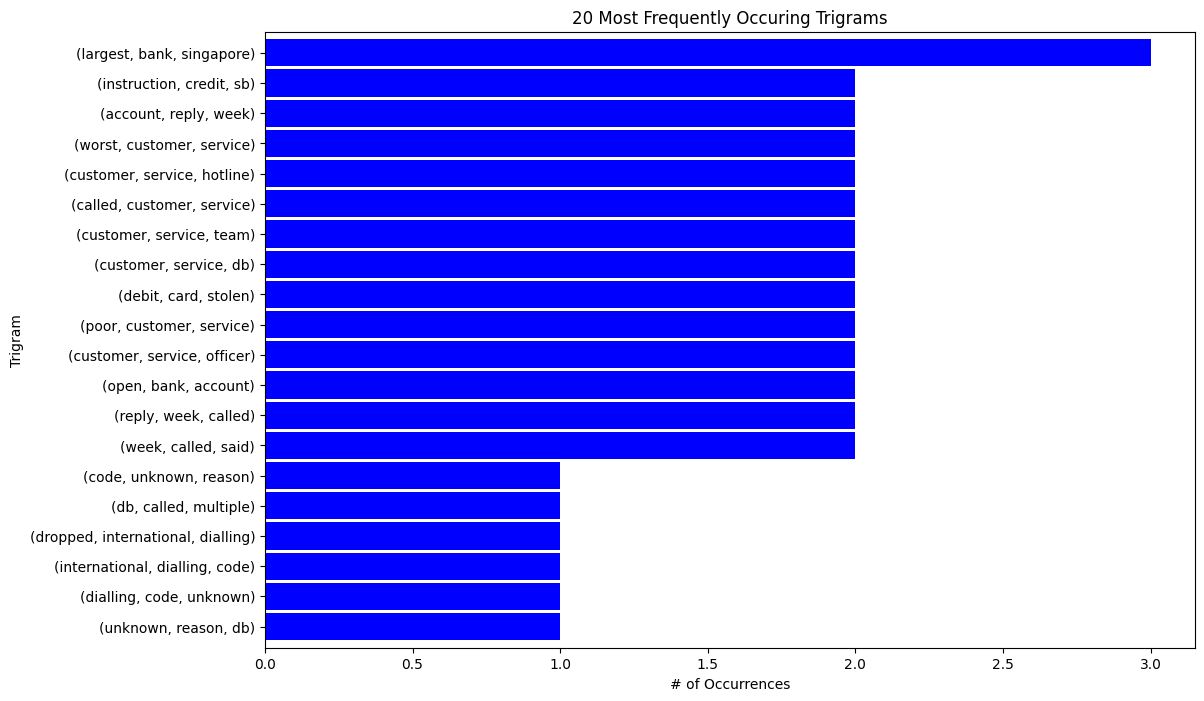

In [ ]:
neg_trigrams_series = (pd.Series(nltk.ngrams(neg_rev, 3)).value_counts())[:20]

neg_trigrams_series.sort_values().plot.barh(color='blue', width=.9, figsize=(12, 8))
plt.title('20 Most Frequently Occuring Trigrams')
plt.ylabel('Trigram')
plt.xlabel('# of Occurrences')

###N-gram for Fullset Reviews

####Unigram

Text(0.5, 0, '# of Occurrences')

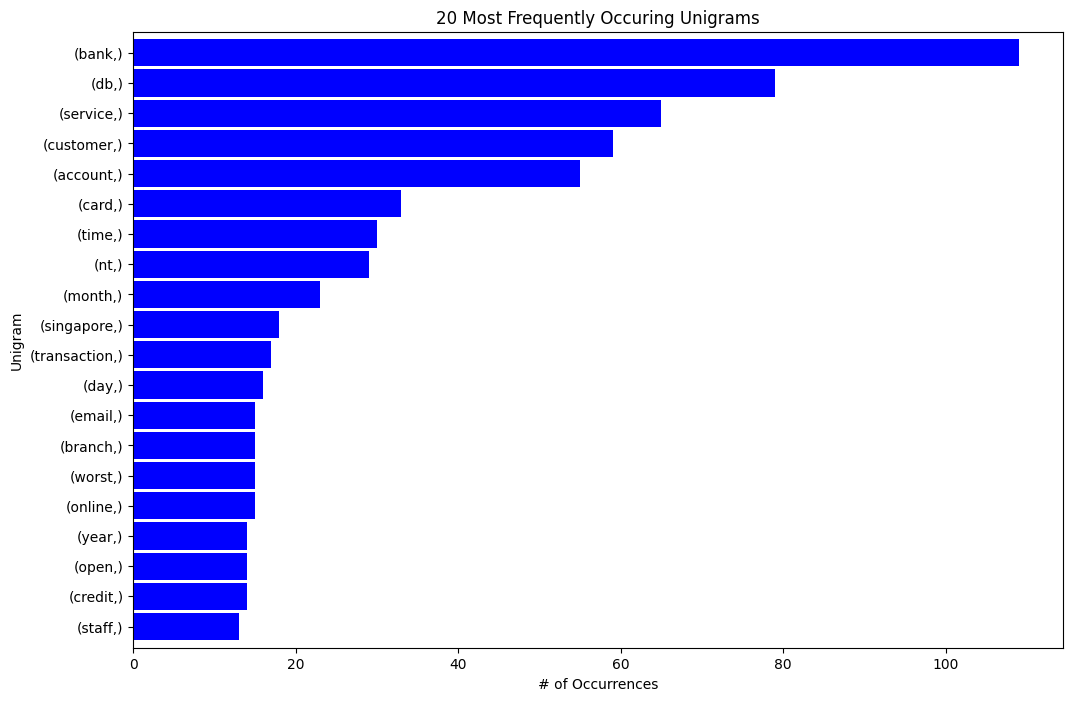

In [ ]:
rev = basic_clean(''.join(str(dbs_rev['Review'].tolist())))

unigrams_series = (pd.Series(nltk.ngrams(rev, 1)).value_counts())[:20]

unigrams_series.sort_values().plot.barh(color='blue', width=.9, figsize=(12, 8))
plt.title('20 Most Frequently Occuring Unigrams')
plt.ylabel('Unigram')
plt.xlabel('# of Occurrences')

####Bigram

Text(0.5, 0, '# of Occurrences')

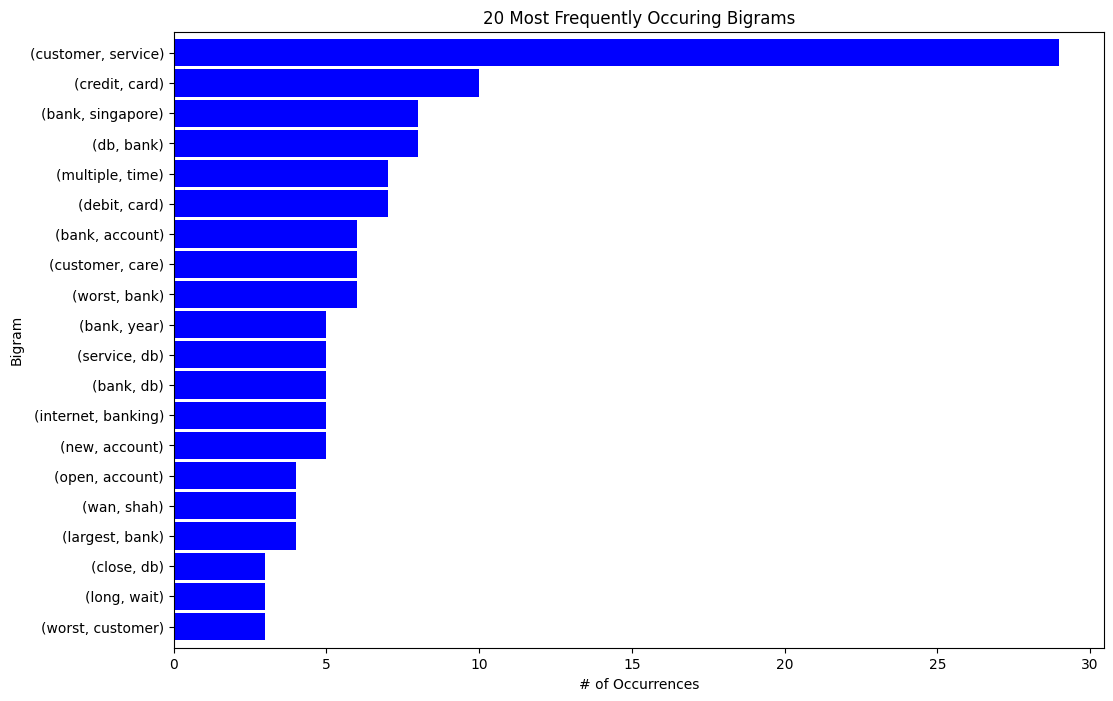

In [ ]:
bigrams_series = (pd.Series(nltk.ngrams(rev, 2)).value_counts())[:20]

bigrams_series.sort_values().plot.barh(color='blue', width=.9, figsize=(12, 8))
plt.title('20 Most Frequently Occuring Bigrams')
plt.ylabel('Bigram')
plt.xlabel('# of Occurrences')

####Trigram

Text(0.5, 0, '# of Occurrences')

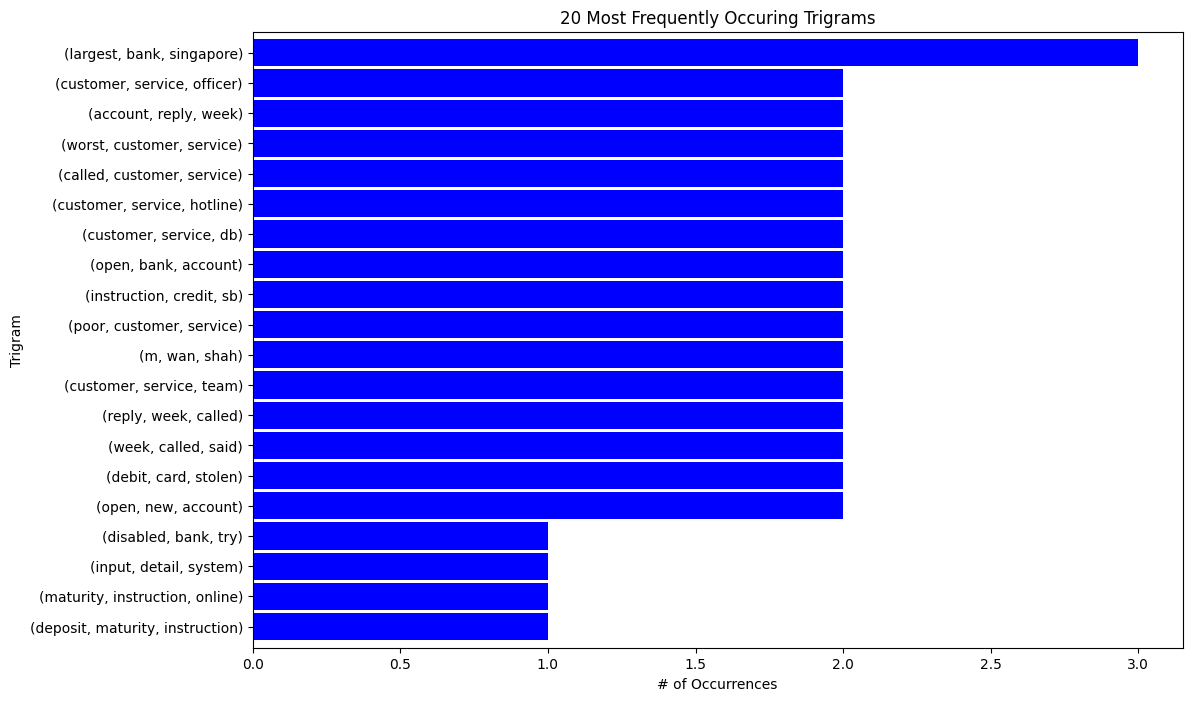

In [ ]:
trigrams_series = (pd.Series(nltk.ngrams(rev, 3)).value_counts())[:20]

trigrams_series.sort_values().plot.barh(color='blue', width=.9, figsize=(12, 8))
plt.title('20 Most Frequently Occuring Trigrams')
plt.ylabel('Trigram')
plt.xlabel('# of Occurrences')